In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [2]:
# plotting style (optional!)
import matplotlib as mpl
from matplotlib import rc
mpl.style.use('classic')
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mlmodern}'

mpl.rc('xtick', labelsize=27) 
mpl.rc('ytick', labelsize=27)
mpl.rc('xtick', labelsize=27) 
mpl.rc('ytick', labelsize=27)

mpl.rcParams['xtick.major.size'] = 10.0
mpl.rcParams['xtick.major.width'] = 1.75
mpl.rcParams['ytick.major.size'] = 10.0
mpl.rcParams['ytick.major.width'] = 1.75

mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams['patch.linewidth'] = 2.0
mpl.rcParams['xtick.major.pad'] = 10.0
mpl.rcParams['ytick.major.pad'] = 10.0

mpl.rcParams['xtick.top'] = False
mpl.rcParams['ytick.right'] = False

mpl.rcParams['xtick.minor.size'] = 5.0
mpl.rcParams['xtick.minor.width'] = 1.75
mpl.rcParams['ytick.minor.size'] = 5.0
mpl.rcParams['ytick.minor.width'] = 1.75

mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.top'] = True

import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

In [3]:
# simple model for Gaia's astrometric uncertainty
def piecewise(x, a):
    return a*np.max([1.0*np.ones(len(x)), 10**(0.2*(x - 14.0))], axis=0)

In [4]:
# function to load data for maximum orbital period experiment
def load_fit_results(filename, tot_num_runs=96, tot_num_loops=10_000, rand_subset=0):
    astrom_SNRs, chi2_diffs, BIC_diffs, true_Porbs, recov_Porbs, true_mps, recov_mps, true_incs, recov_incs, true_eccs, recov_eccs = [], [], [], [], [], [], [], [], [], [], []
    for run_num in tqdm(range(tot_num_runs)):
        for loop_num in range(tot_num_loops):
            try:
                f = open("Data/" + filename + "/file" + str(run_num) + "_" + str(loop_num) + ".pkl", "rb")
                stellar_params = pickle.load(f) # [ra, dec, parallax, pmra, pmdec, mass, G-mag]
                astrom_data = pickle.load(f) # [t_ast_yr, psi, plx_factor, ast_obs, ast_err]
                true_params = pickle.load(f) # [planet_mass, period, Tp, ecc, omega, inc, w]
                recov_params = pickle.load(f) # [planet_mass, period, Tp, ecc, omega, inc, w]
                no_pl_chi2s = pickle.load(f) # float
                one_pl_chi2s = pickle.load(f) # float
                f.close()

                semi_a = ((true_params[1]/365.25)**(2/3))*(stellar_params[5]**(1/3)) # AU
                dist = 1000/stellar_params[2] # pc
                astrom_signal = 1e6*(true_params[0]/stellar_params[5])*(semi_a/dist)
                sigma_fov = piecewise(np.array([stellar_params[6]]), 53.89888779)[0]
                no_pl_BIC = no_pl_chi2s + 5*np.log(len(astrom_data[0]))
                one_pl_BIC = one_pl_chi2s + 12*np.log(len(astrom_data[0]))

                astrom_SNRs.append(astrom_signal/sigma_fov)
                chi2_diffs.append(no_pl_chi2s - one_pl_chi2s)
                BIC_diffs.append(no_pl_BIC - one_pl_BIC)
                true_Porbs.append(true_params[1])
                recov_Porbs.append(recov_params[1])
                true_mps.append(true_params[0])
                recov_mps.append(recov_params[0])
                true_incs.append(true_params[5])
                recov_incs.append(recov_params[5])
                true_eccs.append(true_params[3])
                recov_eccs.append(recov_params[3])
            except Exception as e: # in case file doesn't exist
                None

    # return all samples
    if rand_subset == 0:
        return np.array(astrom_SNRs), np.array(chi2_diffs), np.array(BIC_diffs), np.array(true_Porbs), np.array(recov_Porbs), np.array(true_mps), np.array(recov_mps), (180.0/np.pi)*np.array(true_incs), (180.0/np.pi)*np.array(recov_incs), np.array(true_eccs), np.array(recov_eccs)
    
    # take random subset of samples
    rand_inds = np.random.choice(np.arange(len(astrom_SNRs)), size=rand_subset, replace=False)
    astrom_SNRs = np.array(astrom_SNRs)[rand_inds]
    chi2_diffs = np.array(chi2_diffs)[rand_inds]
    BIC_diffs = np.array(BIC_diffs)[rand_inds]
    true_Porbs = np.array(true_Porbs)[rand_inds]
    recov_Porbs = np.array(recov_Porbs)[rand_inds]
    true_mps = np.array(true_mps)[rand_inds]
    recov_mps = np.array(recov_mps)[rand_inds]
    true_incs = np.array(true_incs)[rand_inds]
    recov_incs = np.array(recov_incs)[rand_inds]
    true_eccs = np.array(true_eccs)[rand_inds]
    recov_eccs = np.array(recov_eccs)[rand_inds]
    
    return astrom_SNRs, chi2_diffs, BIC_diffs, true_Porbs, recov_Porbs, true_mps, recov_mps, (180.0/np.pi)*true_incs, (180.0/np.pi)*recov_incs, true_eccs, recov_eccs

In [5]:
# function to get medians and standard deviations in bins for the plot
def get_medians_stds(x_arr, y_arr, x_bins):
    x_bin_centers = 0.5*(x_bins[1:] + x_bins[:-1])
    median_ys = np.zeros(len(x_bin_centers))
    lower_ys = np.zeros(len(x_bin_centers))
    upper_ys = np.zeros(len(x_bin_centers))
    for j in range(len(x_bins)-1):
        temp_ys = []
        for i in range(len(x_arr)):
            if x_bins[j] < x_arr[i] < x_bins[j+1]:
                temp_ys.append(y_arr[i])
        
        N = len(temp_ys)
        median_ys[j] = np.median(temp_ys)
        lower_ys[j] = median_ys[j] - np.percentile(temp_ys, 15.9)
        upper_ys[j] = np.percentile(temp_ys, 84.1) - median_ys[j]
        
        
    return x_bin_centers, median_ys, lower_ys, upper_ys

In [6]:
# fix random seed
np.random.seed(0)

In [7]:
# load results for simulated DR4 astrometry
_, _, _, true_Porbs_DR4, recov_Porbs_DR4, _, _, _, _, _, _ = load_fit_results("Pmax_experiment_DR4", rand_subset=10_000)

100%|███████████████████████████████████████████████████████████████████| 96/96 [00:03<00:00, 25.97it/s]


In [8]:
# load results for simulated DR5 astrometry
_, _, _, true_Porbs_DR5, recov_Porbs_DR5, _, _, _, _, _, _ = load_fit_results("Pmax_experiment_DR5", rand_subset=10_000)

100%|███████████████████████████████████████████████████████████████████| 96/96 [00:03<00:00, 26.19it/s]


In [9]:
# get binned medians and standard deviations
true_Porb_bins = np.logspace(0.0, 1.5, 24)
true_Porb_centers, median_recov_Porb_DR4, recov_Porb_lowers_DR4, recov_Porb_uppers_DR4 = get_medians_stds(true_Porbs_DR4/365.25, recov_Porbs_DR4/365.25, true_Porb_bins)
true_Porb_centers, median_recov_Porb_DR5, recov_Porb_lowers_DR5, recov_Porb_uppers_DR5 = get_medians_stds(true_Porbs_DR5/365.25, recov_Porbs_DR5/365.25, true_Porb_bins)

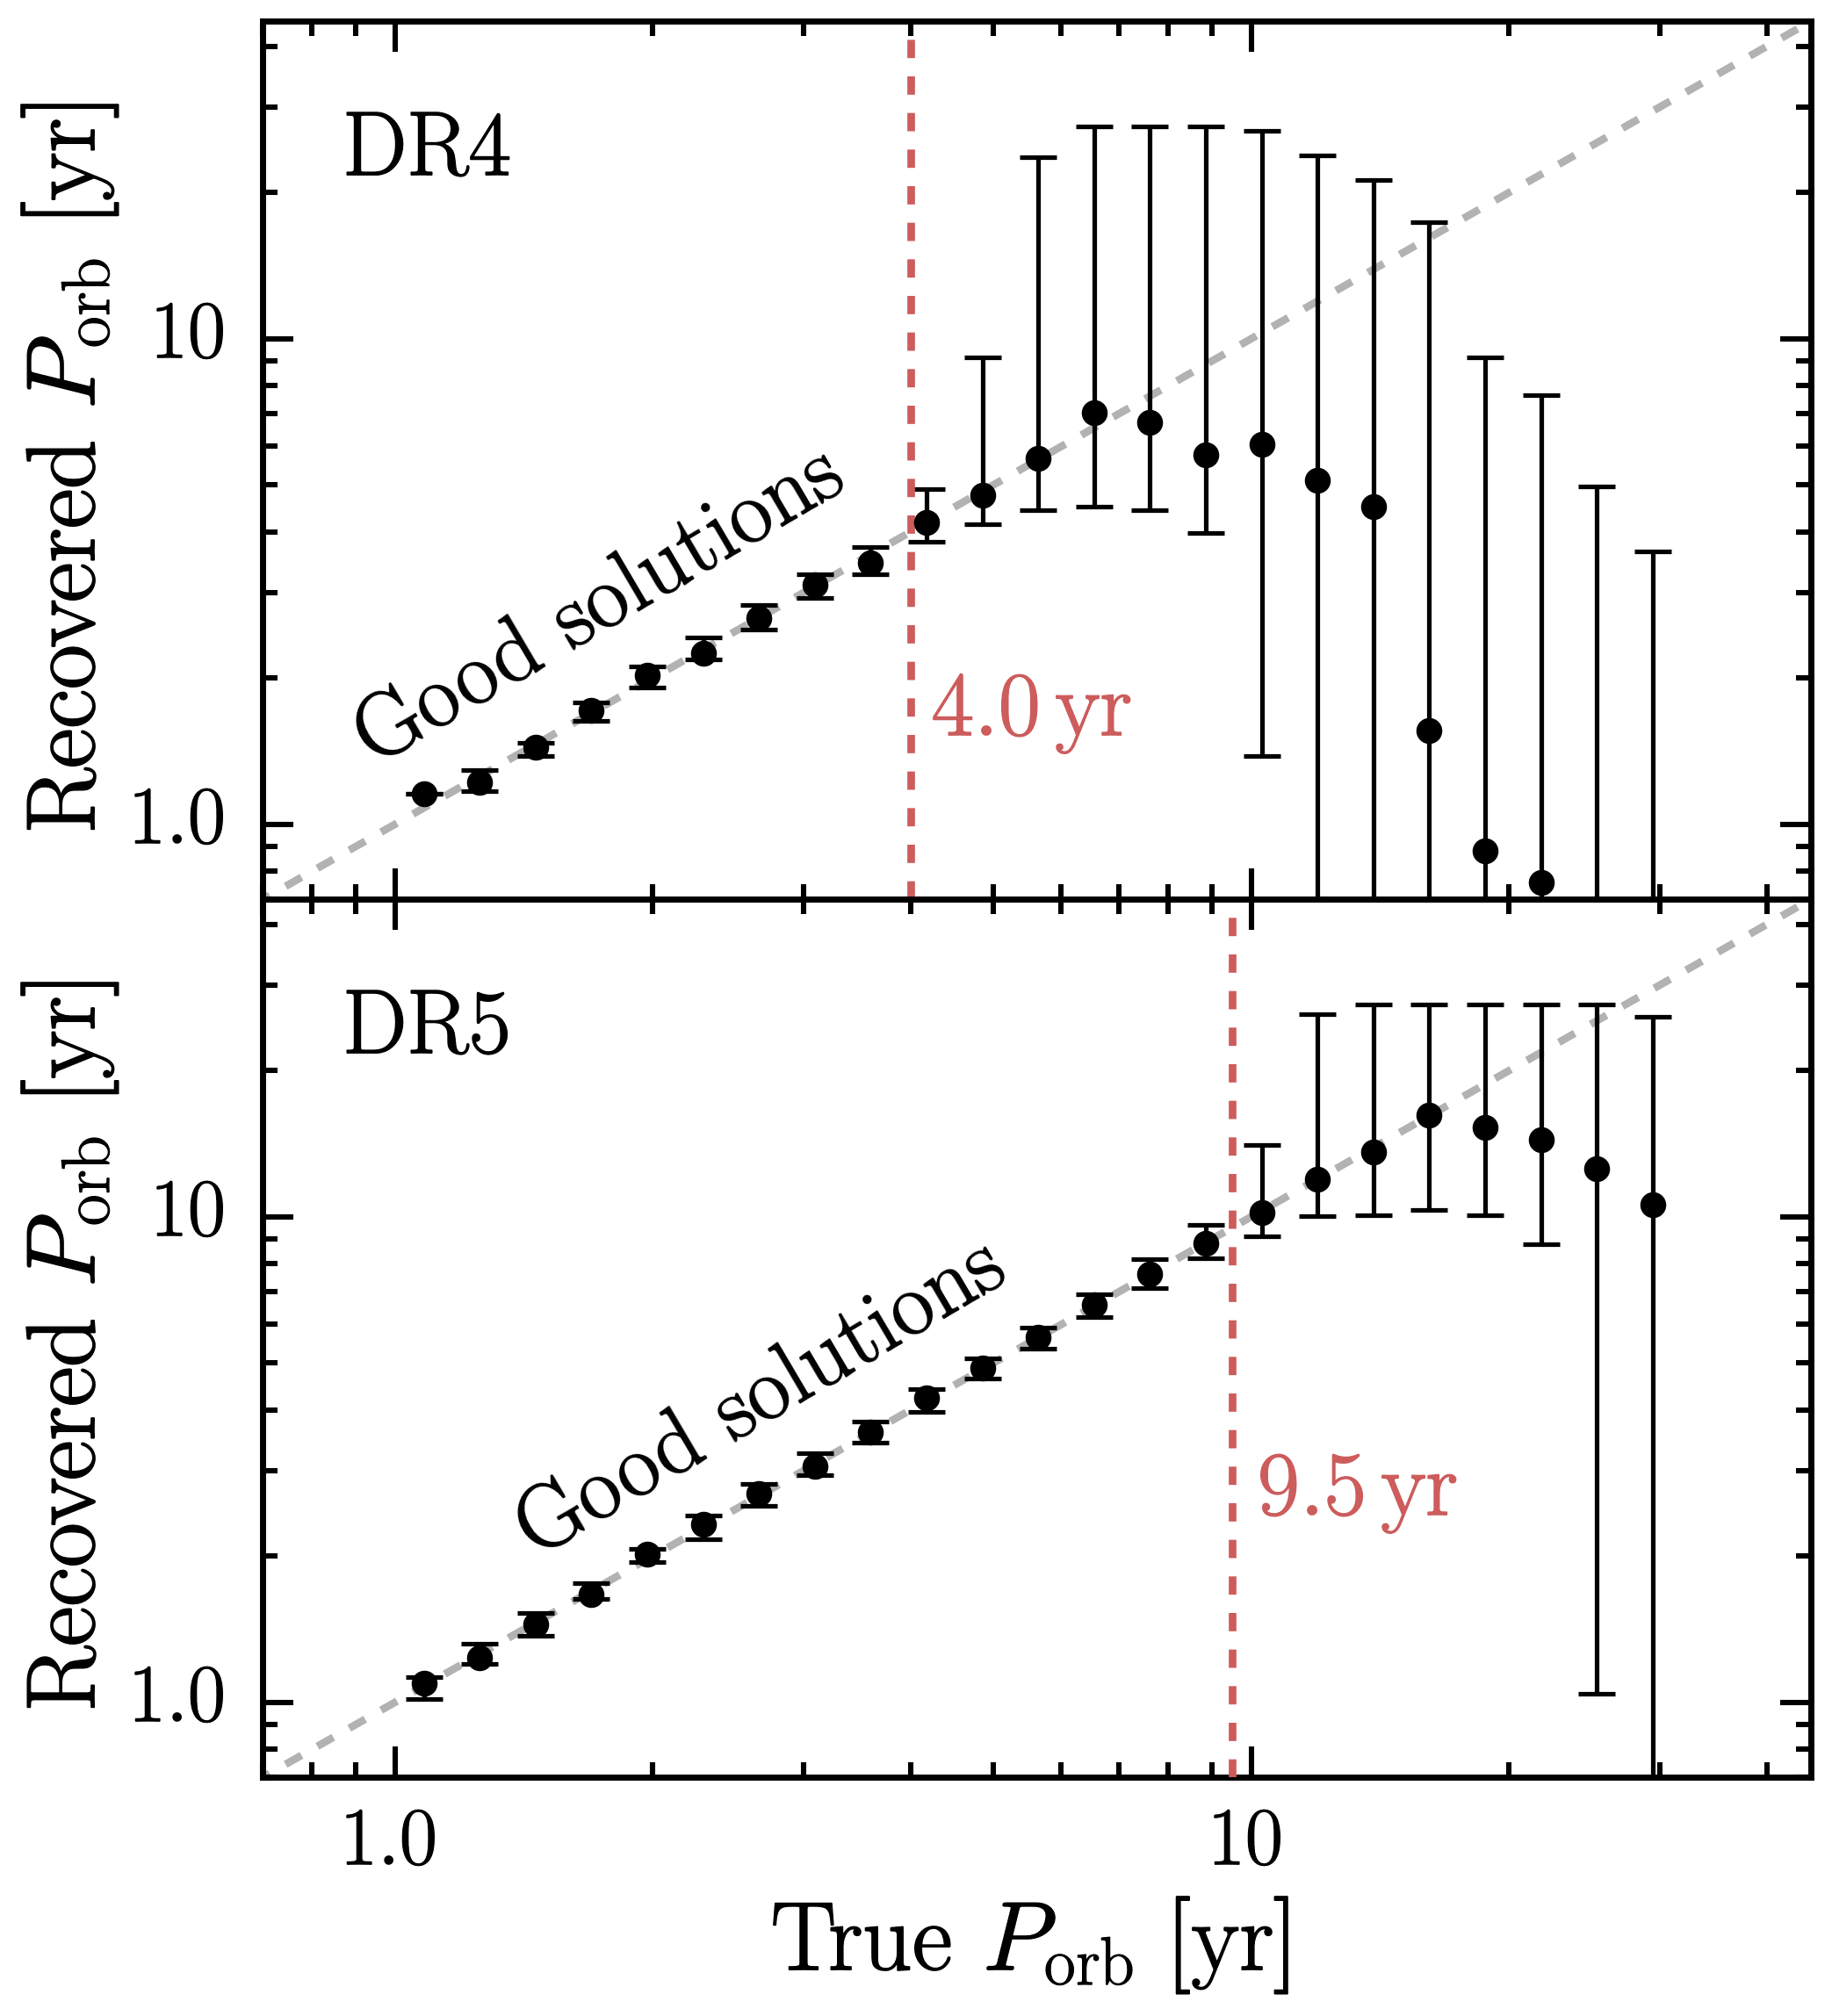

In [10]:
# make plot; DR4 panel
fig, ax = plt.subplots(2, 1, figsize=(9.1, 10.0), dpi=250, sharex=True, facecolor='white')
ax[0].errorbar(true_Porb_centers, median_recov_Porb_DR4, [recov_Porb_lowers_DR4, recov_Porb_uppers_DR4], fmt='o', color='k', ms=8.0, lw=1.5, capsize=6, capthick=1.5, zorder=10)
ax[0].plot(np.linspace(-5.0, 100.0), np.linspace(-5.0, 100.0), c='k', lw=2.5, ls='--', alpha=0.3, zorder=-10)
ax[0].axvline(x=4.0, c='indianred', lw=2.5, ls='--', zorder=10)
ax[0].set_xlabel(r'$\mathrm{True}~P_\mathrm{orb}~\mathrm{[yr]}$', labelpad=5, fontsize=32)
ax[0].set_ylabel(r'$\mathrm{Recovered}~P_\mathrm{orb}~\mathrm{[yr]}$', fontsize=32, labelpad=5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim([7e-1, 45.0])
ax[0].set_ylim([7e-1, 45.0])
ax[0].set_yticks([1.0, 10.0])
ax[0].set_yticklabels([r'$1.0$', r'$10$'])
ax[0].text(1.1, 24, r'$\mathrm{DR4}$', horizontalalignment='center', verticalalignment='center', fontsize=30)
ax[0].text(1.75, 2.8, r'$\mathrm{Good~solutions}$', rotation=30.5, horizontalalignment='center', verticalalignment='center', fontsize=30)
ax[0].text(5.55, 1.7, r'$4.0\,\mathrm{yr}$', horizontalalignment='center', verticalalignment='center', c='indianred', fontsize=30, zorder=20)

# DR5 panel
ax[1].errorbar(true_Porb_centers, median_recov_Porb_DR5, [recov_Porb_lowers_DR5, recov_Porb_uppers_DR5], fmt='o', color='k', ms=8.0, lw=1.5, capsize=6, capthick=1.5, zorder=10)
ax[1].plot(np.linspace(-5.0, 100.0), np.linspace(-5.0, 100.0), c='k', lw=2.5, ls='--', alpha=0.3, zorder=-10)
ax[1].axvline(x=9.5, c='indianred', lw=2.5, ls='--', zorder=10)
ax[1].set_xlabel(r'$\mathrm{True}~P_\mathrm{orb}~\mathrm{[yr]}$', labelpad=5, fontsize=32)
ax[1].set_ylabel(r'$\mathrm{Recovered}~P_\mathrm{orb}~\mathrm{[yr]}$', fontsize=32, labelpad=5)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim([7e-1, 45.0])
ax[1].set_ylim([7e-1, 45.0])
ax[1].set_xticks([1.0, 10.0])
ax[1].set_xticklabels([r'$1.0$', r'$10$'])
ax[1].set_yticks([1.0, 10.0])
ax[1].set_yticklabels([r'$1.0$', r'$10$'])
ax[1].text(1.1, 24, r'$\mathrm{DR5}$', horizontalalignment='center', verticalalignment='center', fontsize=30)
ax[1].text(2.7, 4.2, r'$\mathrm{Good~solutions}$', rotation=30.5, horizontalalignment='center', verticalalignment='center', fontsize=30)
ax[1].text(13.4, 2.7, r'$9.5\,\mathrm{yr}$', horizontalalignment='center', verticalalignment='center', c='indianred', fontsize=30, zorder=20)
plt.subplots_adjust(hspace=0.0)
plt.show()